# 🙌 Analyzing Annotation Metrics with FastFit Model Predictions

In this tutorial, we will train an intent multi-class classifier using the [**FastFit**](https://github.com/IBM/fastfit) library for few-shot classification. Then, we will make some predictions and evaluate the model. Finally, we will simulate the annotation process with Argilla and calculate some of the most well-known annotation metrics.

These are the steps we will follow:

1. Prepare the dataset
2. Train the model with FastFit
3. Make predictions and add them to Argilla
4. Evaluate the annotation performance
   * Accuracy, precision, recall, F1 score with *argilla*
   * Confusion matrix with *sklearn*, *seaborn* and *matplotlib*
   * Krippendorff's alpha with *argilla*
   * Cohen's kappa with *sklearn*
   * Fleiss' kappa with *statsmodels*

Let's get started! 🚀

## Introduction

[**FastFit**](https://github.com/IBM/fastfit) is a library that allows you to train a multi-class classifier with few-shot learning. It is based on the [**transformers**](https://huggingface.co/transformers/) library and uses a pre-trained model to fine-tune it on a small dataset. This is particularly useful when you have a small dataset and you want to train a model quickly. However, [**SetFit**](https://github.com/huggingface/setfit) is another well-know library that also allows few-shot learning with Sentence Transformers.

So, why using one and not the other? Based on this [article](https://pub.towardsai.net/few-shot-nlp-intent-classification-d29bf85548aa), where the author compares FastFit, SetFit, and Semantic Router, we can determine some distinctions.

| **Aspect**                | **FastFit**                                   | **SetFit**                                 |
|---------------------------|-----------------------------------------------|--------------------------------------------|
| **Accuracy**              | High, but may sacrifice accuracy for speed    | Consistently high                          |
| **Training Speed**        | Fast                                          | Slow                                       |
| **Inference Speed**       | Slow                                          | Fast                                       |
| **Deployment**            | Easy, minimal expertise needed                | Requires knowledge of transformers         |
| **Dataset Handling**      | Struggles with highly complex datasets        | Can be fine-tuned for various datasets     |
| **Computational Costs**   | Lower                                         | Higher                                     |

In this tutorial, we will focus on FastFit, but you can also try SetFit and compare the results. To know how to use SetFit, you can check this [tutorial](../../tutorials/feedback/labelling-feedback-setfit.ipynb).

## Running Argilla

For this tutorial, you will need to have an Argilla server running. There are two main options for deploying and running Argilla:


**Deploy Argilla on Hugging Face Spaces**: If you want to run tutorials with external notebooks (e.g., Google Colab) and you have an account on Hugging Face, you can deploy Argilla on Spaces with a few clicks:

[![deploy on spaces](https://huggingface.co/datasets/huggingface/badges/raw/main/deploy-to-spaces-lg.svg)](https://huggingface.co/login?next=%2Fnew-space%3Ftemplate%3Dargilla%2Fargilla-template-space)

For details about configuring your deployment, check the [official Hugging Face Hub guide](https://huggingface.co/docs/hub/spaces-sdks-docker-argilla).


**Launch Argilla using Argilla's quickstart Docker image**: This is the recommended option if you want [Argilla running on your local machine](../../getting_started/quickstart.html). Note that this option will only let you run the tutorial locally and not with an external notebook service.

For more information on deployment options, please check the Deployment section of the documentation.

<div class="alert alert-info">

Tip
    
This tutorial is a Jupyter Notebook. There are two options to run it:

- Use the Open in Colab button at the top of this page. This option allows you to run the notebook directly on Google Colab. Don't forget to change the runtime type to GPU for faster model training and inference.
- Download the .ipynb file by clicking on the View source link at the top of the page. This option allows you to download the notebook and run it on your local machine or a Jupyter Notebook tool of your choice.
</div>

## Set up the Environment

To complete this tutorial, you will need to install the Argilla client and a few third-party libraries using `pip`:

In [ ]:
!pip install argilla fast-fit datasets
!pip install nltk statsmodels seaborn matplotlib 

Let's make the needed imports:

In [ ]:
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from statsmodels.stats.inter_rater import fleiss_kappa

from datasets import Dataset, DatasetDict, load_dataset
from transformers import AutoTokenizer, pipeline

import argilla as rg
from argilla.client.feedback.metrics import ModelMetric, AgreementMetric

from fastfit import FastFit, FastFitTrainer, sample_dataset

If you are running Argilla using the Docker quickstart image or a public Hugging Face Spaces, you need to init the Argilla client with the `URL` and `API_KEY`:

In [ ]:
# Replace api_url with the url to your HF Spaces URL if using Spaces
# Replace api_key if you configured a custom API key
# Replace workspace with the name of your workspace
rg.init(api_url="http://localhost:6900", api_key="owner.apikey", workspace="admin")

If you're running a private Hugging Face Space, you will also need to set the [HF_TOKEN](https://huggingface.co/settings/tokens) as follows:

In [ ]:
# # Set the HF_TOKEN environment variable
# import os
# os.environ['HF_TOKEN'] = "your-hf-token"

# # Replace api_url with the url to your HF Spaces URL
# # Replace api_key if you configured a custom API key
# rg.init(
#     api_url="https://[your-owner-name]-[your_space_name].hf.space",
#     api_key="admin.apikey",
#     extra_headers={"Authorization": f"Bearer {os.environ['HF_TOKEN']}"},
# )

### Enable Telemetry

We gain valuable insights from how you interact with our tutorials. To improve ourselves in offering you the most suitable content, using the following lines of code will help us understand that this tutorial is serving you effectively. Though this is entirely anonymous, you can choose to skip this step if you prefer. For more info, please check out the [Telemetry](../../reference/telemetry.md) page.

In [ ]:
try:
    from argilla.utils.telemetry import tutorial_running

    tutorial_running()
except ImportError:
    print(
        "Telemetry is introduced in Argilla 1.20.0 and not found in the current installation. Skipping telemetry."
    )

## Preparing the Dataset

First, we will prepare the dataset to train the intent classifier, which is responsible for accurately labeling natural language utterances with predefined intents. [FastFit](https://github.com/IBM/fastfit) is particularly effective for few-shot, multi-class classification, especially in scenarios with many semantically similar classes. Therefore, we have chosen to use the [contemmcm/clinc150](https://huggingface.co/datasets/contemmcm/clinc150) dataset from Hugging Face. This dataset includes 151 intent classes, making it well-suited for our needs.

In [55]:
# Load the dataset
hf_dataset = load_dataset("contemmcm/clinc150", split="complete")
hf_dataset

Dataset({
    features: ['text', 'domain', 'intent', 'split'],
    num_rows: 23700
})

In [56]:
# Get the 151 classes and prepare the conversion dictionaries
labels = [label for label in hf_dataset.features["intent"].names if label]
label2id = {label: id for id, label in enumerate(labels)}
id2label = {id: label for label, id in label2id.items()}
len(labels)

151

The dataset doesn't come with predefined partitions, so we will split it based on the `split` column, selecting only the `train`, `validation`, and `test` splits. We will retain only the `text` and `intent` columns, converting the intent IDs to labels.

In [57]:
# Save the needed data
splits = ["train", "val", "test"]

data = {split: {"text": [], "intent": []} for split in splits}

for split in splits:
    for entry in hf_dataset:
        if entry["split"] == split:
            data[split]["text"].append(entry["text"])
            data[split]["intent"].append(id2label[entry["intent"]])

# Create the dataset
dataset = DatasetDict({split: Dataset.from_dict(data[split]) for split in data})

Since this is few-shot learning, we don't need to use all the examples in the training set. Therefore, we will utilize the `sample_dataset` method from FastFit to select 10 examples per class (since FastFit is faster to train, we can afford to include more samples without worrying about significantly increased training times). Additionally, we will rename the `val` split to `validation` to comply with FastFit requirements.

In [60]:
# Sample the dataset
dataset["train"] = sample_dataset(
    dataset["train"], label_column="intent", num_samples_per_label=10, seed=42
)

# Rename the validation split
dataset["validation"] = dataset.pop("val")

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'intent'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['text', 'intent'],
        num_rows: 4500
    })
    validation: Dataset({
        features: ['text', 'intent'],
        num_rows: 3000
    })
})

## Training with FastFit

As we mentioned, [FastFit](https://github.com/IBM/fastfit) is a library for few-shot learning that can be used to train a model with a few examples per class. In addition, they created the [FewMany benchmark](https://arxiv.org/html/2404.12365v1) for multi-class classification.

In this case, we have chosen to use the [sentence-transformers/paraphrase-mpnet-base-v2](https://huggingface.co/sentence-transformers/paraphrase-mpnet-base-v2) model to train the intent classifier due to its size and performance. However, you can explore other models available on Hugging Face and find the most appropriate one by consulting the [MTEB leaderboard](https://huggingface.co/spaces/mteb/leaderboard). Most of the arguments set in the `FastFitTrainer` are the default values, but you can change them according to your needs.

In [ ]:
# Initialize the FastFitTrainer
trainer = FastFitTrainer(
    model_name_or_path="sentence-transformers/paraphrase-mpnet-base-v2",
    label_column_name="intent",
    text_column_name="text",
    num_train_epochs=25,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    max_text_length=128,
    dataloader_drop_last=False,
    num_repeats=4,
    optim="adafactor",
    clf_loss_factor=0.1,
    fp16=True,
    dataset=dataset,
)

In [232]:
# Train the model
model = trainer.train()

Step,Training Loss
500,2.676200
1000,2.590300


***** train metrics *****
  epoch                    =       25.0
  total_flos               =        0GF
  train_loss               =     2.6261
  train_runtime            = 0:02:59.32
  train_samples            =       1500
  train_samples_per_second =    209.121
  train_steps_per_second   =      6.552


As we can see, the training time took only 3 minutes, which is quite quick. Now, let’s evaluate the model to check its accuracy. After evaluation, we will save the model to disk for the inference step.

In [234]:
# Evaluate the model
results = trainer.evaluate()

***** eval metrics *****
  epoch                   =       25.0
  eval_accuracy           =      0.947
  eval_loss               =     2.9615
  eval_runtime            = 0:00:04.30
  eval_samples            =       3000
  eval_samples_per_second =    697.334
  eval_steps_per_second   =     10.925


In [236]:
# Save the model
model.save_pretrained("intent_fastfit_model")

## Inferring with our Model

As we have seen, looks like we have a model ready to make predictions. Let's load the model and the tokenizer.

In [52]:
# Load the model and tokenizer
model = FastFit.from_pretrained("intent_fastfit_model")
tokenizer = AutoTokenizer.from_pretrained(
    "sentence-transformers/paraphrase-mpnet-base-v2"
)

Next, we will prepare our pipeline.

> An error warning is raised when initializing the pipeline: `The model 'FastFit' is not supported for text-classification`. However, the classifier will work properly.

> If you have changed the base model, you may encounter a `token_type_ids` error. You can solve it as noted [here](https://github.com/IBM/fastfit/issues/6).

We will set `top_k=1` to get the most likely class for each prediction. If you want to get all the predicted classes, set it to `None`.

In [ ]:
# Define the pipeline
classifier = pipeline("text-classification", model=model, tokenizer=tokenizer, top_k=1)

So, let's make some predictions! For the purpose of this tutorial, we will use the validation split and only the first 100 samples. As observed during our initial run, making predictions took over a minute. Therefore, as noted in the introduction, if we needed to make more predictions, it would be slow.

In [61]:
# Make predictions
predictions = [
    {
        "text": sample["text"],
        "true_intent": sample["intent"],
        "predicted_intent": classifier(sample["text"]),
    }
    for sample in dataset["validation"].to_list()[:100]
]

In [62]:
for p in predictions[:5]:
    print(p)

{'text': "what's the weather today", 'true_intent': 'utility:weather', 'predicted_intent': [[{'label': 'utility:weather', 'score': 0.8783325552940369}]]}
{'text': 'what are the steps required for making a vacation request', 'true_intent': 'work:pto_request', 'predicted_intent': [[{'label': 'work:pto_request', 'score': 0.9850018620491028}]]}
{'text': 'help me set a timer please', 'true_intent': 'utility:timer', 'predicted_intent': [[{'label': 'utility:timer', 'score': 0.8667100071907043}]]}
{'text': 'what is the mpg for this car', 'true_intent': 'auto_and_commute:mpg', 'predicted_intent': [[{'label': 'auto_and_commute:mpg', 'score': 0.9732610583305359}]]}
{'text': 'was my last transaction at walmart', 'true_intent': 'banking:transactions', 'predicted_intent': [[{'label': 'banking:transactions', 'score': 0.9001362919807434}]]}


## Annotate with Argilla

We will simulate the annotation process using Argilla. First, we need to create a dataset. We will use a predefined Task Template for text classification, specifying only the labels to be annotated.

> For a more detailed explanation of the Task Template or customize a dataset, check the [Argilla documentation](../../../practical_guides/create_update_dataset/create_dataset.html).

In [25]:
# Define the feedback dataset
dataset = rg.FeedbackDataset.for_text_classification(
    labels=labels,
)
dataset

FeedbackDataset(
   fields=[TextField(name='text', title='Text', required=True, type='text', use_markdown=False)]
   questions=[LabelQuestion(name='label', title='Label', description='Classify the text by selecting the correct label from the given list of labels.', required=True, type='label_selection', labels=['oos:oos', 'banking:freeze_account', 'banking:routing', 'banking:pin_change', 'banking:bill_due', 'banking:pay_bill', 'banking:account_blocked', 'banking:interest_rate', 'banking:min_payment', 'banking:bill_balance', 'banking:transfer', 'banking:order_checks', 'banking:balance', 'banking:spending_history', 'banking:transactions', 'banking:report_fraud', 'credit_cards:replacement_card_duration', 'credit_cards:expiration_date', 'credit_cards:damaged_card', 'credit_cards:improve_credit_score', 'credit_cards:report_lost_card', 'credit_cards:card_declined', 'credit_cards:credit_limit_change', 'credit_cards:apr', 'credit_cards:redeem_rewards', 'credit_cards:credit_limit', 'credit_card

The standard annotation process involves adding records to the dataset with the text to be annotated and the predicted labels along with their scores as suggestions to assist the annotators. However, for this tutorial and to simulate the annotation process, we will also add responses. Specifically, we will add three responses for each record: one with the correct label, one with a random label (either the correct one or a different one), and one with the predicted label.

> To know how to create a user, check the [Argilla documentation](../../../getting_started/installation/configurations/user_management.md).

In [26]:
# Get the list of users
users = rg.User.list()

# Define the feedback records
records = [
    rg.FeedbackRecord(
        fields={
            "text": sample["text"],
        },
        suggestions=[
            {
                "question_name": "label",
                "value": sample["predicted_intent"][0][0]["label"],
                "score": round(sample["predicted_intent"][0][0]["score"], 2),
            }
        ],
        responses=[
            {
                "values": {
                    "label": {
                        "value": sample["true_intent"],
                    }
                },
                "user_id": users[0].id,
            },
            {
                "values": {
                    "label": {
                        "value": random.choice([sample["true_intent"], labels[0]]),
                    }
                },
                "user_id": users[1].id,
            },
            {
                "values": {
                    "label": {
                        "value": sample["predicted_intent"][0][0]["label"],
                    }
                },
                "user_id": users[2].id,
            },
        ],
    )
    for sample in predictions
]
dataset.add_records(records)

We can push the dataset to Argilla to be visualized in the UI.

In [ ]:
dataset.push_to_argilla(name="intent_feedback_dataset", workspace="admin")

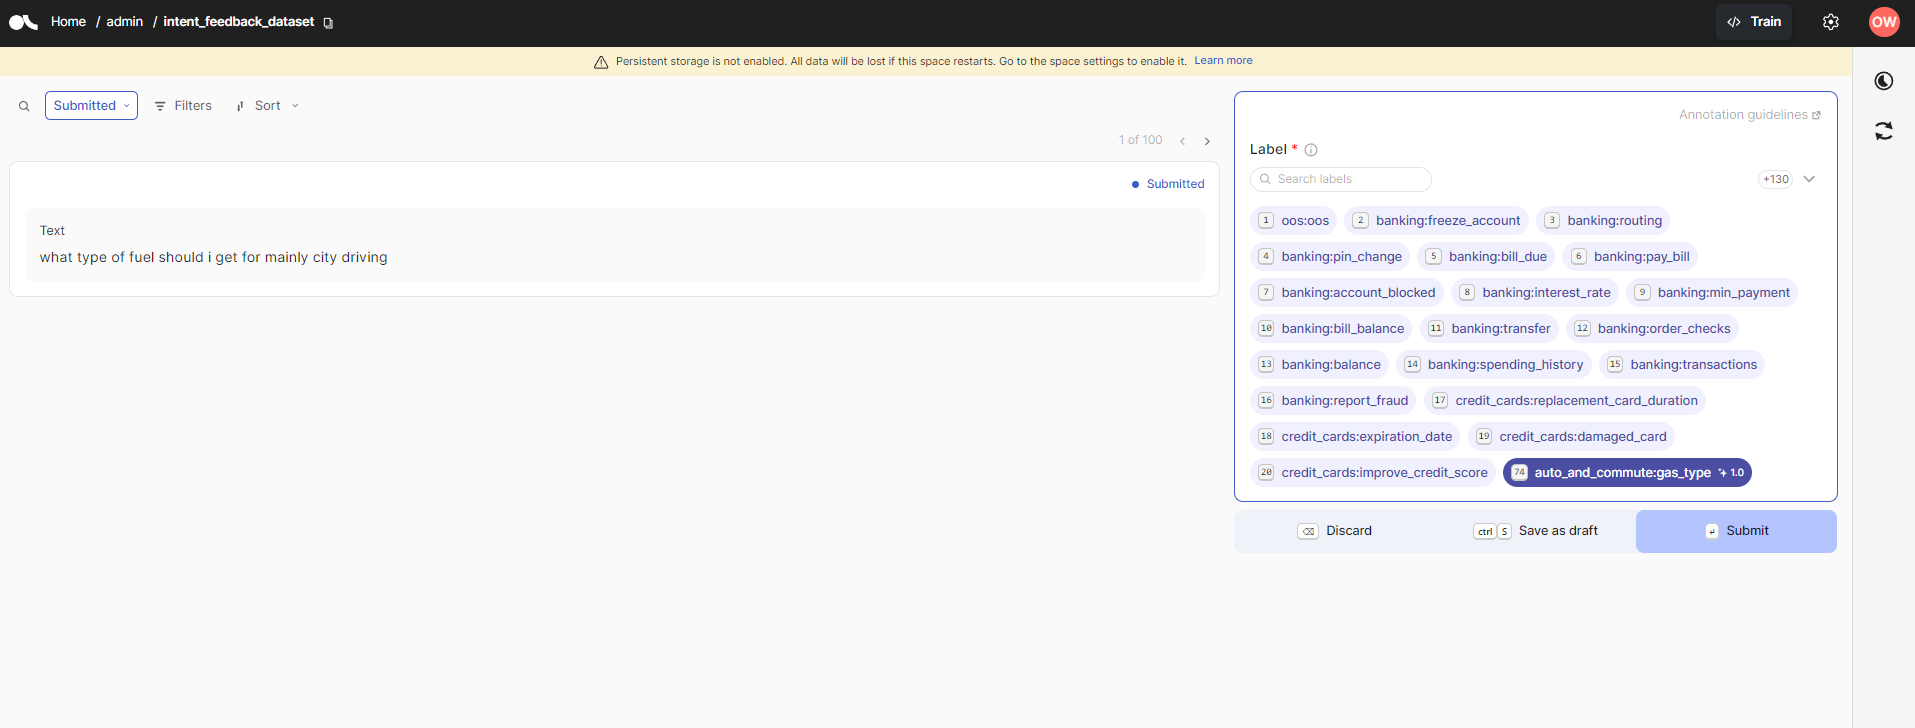

## Analyzing the Annotation Performance

Once our dataset is annotated, we can analyze the annotation performance in different ways. First, we will need to retrieve the annotated dataset and save the needed information to calculate the metrics.

In [40]:
# Retrieve the annotated dataset
feedback_dataset = rg.FeedbackDataset.from_argilla(
    name="intent_feedback_dataset", workspace="admin"
)

In [ ]:
# Save the list of responses by annotator
responses_by_annotator = {}
for record in feedback_dataset.records:
    if record.responses:
        submitted_responses = [
            response for response in record.responses if response.status == "submitted"
        ]
        for response in submitted_responses:
            print(response)
            annotator_id = str(response.user_id)
            if annotator_id not in responses_by_annotator:
                responses_by_annotator[annotator_id] = []
            responses_by_annotator[annotator_id].append(response.values["label"].value)

In [ ]:
# You can check the responses directly using the id of the annotator
responses_by_annotator[str(users[0].id)]

# or the name of the annotator
responses_by_annotator[str(rg.User.from_name("argilla").id)]

### Accuracy, Precision, Recall, and F1 Score

Argilla allows you to calculate the accuracy, precision, recall, and F1 score for the annotated dataset. It will compare the suggested labels with the annotated ones and calculate the metrics for each record and the dataset as a whole.

> For more information on the metrics, check the [Argilla documentation](../../../practical_guides/collect_responses.md).

In [ ]:
# List of metrics to compute
metrics = ["accuracy", "precision", "recall", "f1-score"]

# Initialize the ModelMetric object
metric = ModelMetric(dataset=feedback_dataset, question_name="label")

# Save the metrics per annotator
annotator_metrics = {}
for metric_name in metrics:
    annotator_metrics[metric_name] = metric.compute(metric_name)

This setup allows us to observe an annotator with perfect accuracy and another with mid-level performance. Given that the suggestions are predictions and their reliability is uncertain, this simulation helps us assess if an annotator has been influenced by the suggestions or if they are accurately annotating independently. This way, we can better understand the impact of suggestions on annotation quality.

In [43]:
annotator_metrics["accuracy"]

{'e106d194-10b6-4608-a2e9-aea40cfd90d0': [ModelMetricResult(metric_name='accuracy', count=100, result=0.92)],
 '0bcc381d-0c77-4ef8-8de0-83417fd5a80b': [ModelMetricResult(metric_name='accuracy', count=100, result=0.45)],
 '13f90c69-1cb8-42c2-a861-491f25878ff3': [ModelMetricResult(metric_name='accuracy', count=100, result=1.0)]}

### Confusion Matrix

A useful tool for understanding the annotation performance is visualizing the confusion matrix. It shows the number of correct and incorrect annotations for each class, allowing us to identify which classes are more challenging for the annotators. You can calculate it using **sklearn**'s `confusion_matrix` function and plot it with **seaborn** and **matplotlib**.

In [ ]:
# Compute the confusion matrix for annotator 2 (his responses were the predicted labels)
true_labels = responses_by_annotator[str(users[2].id)]
predicted_labels = [sample["predicted_intent"][0][0]["label"] for sample in predictions]

confusion_matrix = confusion_matrix(true_labels, predicted_labels)

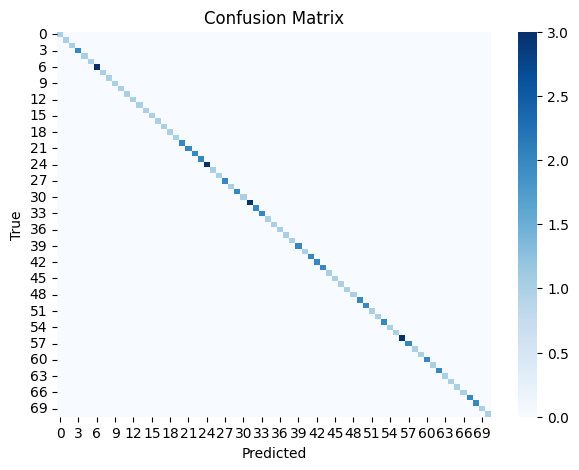

In [ ]:
# Create a heatmap with seaborn and matplotlib
plt.figure(figsize=(7, 5))
sns.heatmap(confusion_matrix, annot=False, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# plt.savefig('confusion_matrix.png', dpi=300) # save the image

In the figure above, the diagonal represents the correct annotations, where the color intensity indicates the number of annotations. The off-diagonal elements would represent the incorrect annotations, which are also color-coded, but in this case, looks like the annotations of the annotator 2 match the true labels. Take into account that the number of labels is lower than 151 because we are using a subset of the validation split.

### Krippendorff's Alpha

For inter-annotator agreement, Argilla allows you to calculate Krippendorff's alpha. This metric is widely used in the annotation field to measure the agreement between two or more annotators and is considered one of the most reliable. It ranges from 0 to 1, where 0 indicates no agreement and 1 perfect agreement.

> For more information on the metric, check the [Argilla documentation](../../../practical_guides/collect_responses.md).

In [ ]:
# Compute Krippendorff's Alpha
metric = AgreementMetric(dataset=feedback_dataset, question_name="label")
agreement_metric = metric.compute("alpha")

We see a medium level of agreement between the annotators, which is expected given that annotator 1 provided a randomized response.

In [3]:
agreement_metric

AgreementMetricResult(metric_name='alpha', count=300, result=0.6131595970797523)

### Cohen's Kappa

Coher's kappa is another metric used to measure the agreement but only between two annotators labeling the same data. It takes into account the possibility of agreement occurring by chance. It ranges from -1 to 1, where 1 indicates perfect agreement, 0 is no agreement, and -1 is complete disagreement. We can calculate it using **sklearn**'s `cohen_kappa_score` function.

In [49]:
# Compute Cohen's Kappa for each pair of annotators
annotator1_2 = cohen_kappa_score(
    responses_by_annotator[str(users[0].id)], responses_by_annotator[str(users[1].id)]
)
annotator2_3 = cohen_kappa_score(
    responses_by_annotator[str(users[1].id)], responses_by_annotator[str(users[2].id)]
)
annotator1_3 = cohen_kappa_score(
    responses_by_annotator[str(users[0].id)], responses_by_annotator[str(users[2].id)]
)

In [51]:
print(f"Cohen's Kappa between annotator 1 and 2: {annotator1_2}")
print(f"Cohen's Kappa between annotator 2 and 3: {annotator2_3}")
print(f"Cohen's Kappa between annotator 1 and 3: {annotator1_3}")

Cohen's Kappa between annotator 1 and 2: 0.5059985885673959
Cohen's Kappa between annotator 2 and 3: 0.44567627494456763
Cohen's Kappa between annotator 1 and 3: 0.9187074484300376


We observed a high level of agreement between the annotators 1 (responses based on true labels) and 3 (responses based on predicted labels). However with annotator 2 the agreement is lower due to the randomized answers.

### Fleiss' Kappa

Fleiss' kappa is similar to Cohen's kappa but allows for more than two annotators. Similarly, it ranges from -1 to 1, where 1 indicates perfect agreement, 0 is no agreement, and -1 is complete disagreement. We can calculate it using the `fleiss_kappa` function from **statsmodels**.

In [81]:
# Initialize ratings matrix with the number of records and labels
ratings = np.zeros((100, 151))

# Populate the matrix
for annotator, responses in responses_by_annotator.items():
    for i, response in enumerate(responses):
        ratings[i, label2id[response]] += 1

# Compute Fleiss' Kappa
kappa = fleiss_kappa(ratings, method="fleiss")

We can see that the agreement is similar to Krippendorff's alpha that also evaluates more than two annotators.

In [85]:
print("Fleiss' Kappa:", kappa)

Fleiss' Kappa: 0.611865816467979


## Conclusions

In this tutorial, we trained an intent classifier using FastFit, made predictions, and simulated the annotation process with Argilla. Annotator 1's responses were based on the true labels, annotator 2 alternated between true and incorrect labels, and annotator 3's responses were based on the predicted labels. Then, we calculated the annotation metrics, including accuracy, precision, recall, F1 score, Krippendorff's alpha, Cohen's kappa, and Fleiss' kappa. We also visualized the confusion matrix to understand the annotation performance better. These metrics showcased a great performance and agreement of annotators 1 and 3, while the overall agreement was moderate due to annotator 2's responses.